In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

## Constants

In [3]:
X_START = 0
X_END = 1
T_START = 0
T_END = 0.25
NX = 200
NT = int((T_END - T_START)/0.0001)
ALPHA = 1./jnp.pi**2

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX)
dx = x[1] - x[0]

t = jnp.linspace(T_START, T_END, NT + 1)
dt = t[1] - t[0]

In [5]:
beta = dt/dx

## Initial Conditions

In [6]:
u = jnp.sin(2. * jnp.pi * x)

## Helper Functions

In [7]:
@jax.jit
def nodal_flux(u):
    return (u**2)/2.

@jax.jit
def flux_psplit(f_arr, umax, u):
    return 0.5 * (f_arr + umax * u)

@jax.jit
def flux_msplit(f_arr, umax, u):
    return 0.5 * (f_arr - umax * u) 

@partial(jax.jit, static_argnames=('NX',)) 
def max_u(u, NX, xsU):
    
    carry_init = 0
   
    def max_u_each_step(carry, x):
        def case_0(carry, u):
            temp = jnp.asarray((u[-2], u[-1], u[0], u[1], u[2]))
            return carry + 1, jnp.max(jnp.absolute(temp), keepdims=False)
        def case_1(carry, u):
            temp = jnp.asarray((u[-1], u[0], u[1], u[2], u[3]))
            return carry + 1, jnp.max(jnp.absolute(temp), keepdims=False)
        def case_N_m_2(carry, u):
            temp = jnp.asarray((u[NX-4], u[NX-3], u[NX-2], u[NX-1], u[0]))
            return carry + 1, jnp.max(jnp.absolute(temp), keepdims=False)
        def case_N_m_1(carry, u):
            temp = jnp.asarray((u[NX-3], u[NX-2], u[NX-1], u[0], u[1]))
            return carry + 1, jnp.max(jnp.absolute(temp), keepdims=False)
        def normal(carry, u):
            temp =  jax.lax.dynamic_slice_in_dim(u, carry - 2, 5)
            return carry + 1, jnp.max(jnp.absolute(temp), keepdims=False)                     
        return jax.lax.switch(x, (normal, case_0, case_1, case_N_m_2, case_N_m_1), carry, u)
    
    return jax.lax.scan(max_u_each_step, carry_init, xsU)

In [8]:
# reconstructor for Left side
@jax.jit
def wcL(u_sliced, umax):
    eps = 1e-6
    
    f = nodal_flux(u_sliced)
    # umax = jax.lax.dynamic_index_in_dim(u_max_arr, carry)
    v1, v2, v3, v4, v5 = flux_psplit(f, umax, u_sliced)
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 + v5)**2
    
    c1 = 1e-1/(eps + s1)**2
    c2 = 6e-1/(eps + s2)**2
    c3 = 3e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    q1 = v1/3. - (7./6.) * v2 + (11./6.) * v3
    q2 = -v2/6. + (5./6.) * v3 + v4/3.
    q3 = v3/3. + (5./6.) * v4 - v5/6.
    
    return w1*q1 + w2*q2 + w3*q3 


## reconstructor for the right side
@jax.jit
def wcR(u_sliced, umax):
    eps = 1e-6
    
    f = nodal_flux(u_sliced)
    # umax = max_u(u_sliced)
    v1, v2, v3, v4, v5 = flux_msplit(f, umax, u_sliced)
    
    s1 = (13. / 12.) * (v1 - 2. * v2 + v3)**2 + 0.25 * (v1 - 4. * v2 + 3. * v3)**2
    s2 = (13. / 12.) * (v2 - 2. * v3 + v4)**2 + 0.25 * (v2 - v4)**2
    s3 = (13. / 12.) * (v3 - 2. * v4 + v5)**2 + 0.25 * (3. * v3 - 4. * v4 +  v5)**2
    
    c1 = 3e-1/(eps + s1)**2
    c2 = 6e-1/(eps + s2)**2
    c3 = 1e-1/(eps + s3)**2
    
    c_sum = c1 + c2 + c3
    
    w1 = c1/c_sum
    w2 = c2/c_sum
    w3 = c3/c_sum
    
    q1 = -v1/6. + (5./6.) * v2 +  v3/3.
    q2 = v2/3. + (5./6.) * v3 -  v4/6.
    q3 = (11./ 6.) * v3 - (7./6.) * v4 + v5/3.
    
    return w1*q1 + w2*q2 + w3*q3

In [9]:
## calculating the reconstructed flux and filling it in an array
@partial(jax.jit, static_argnames=('NX',))
def wenoL(u, NX, xs, max_u_arr):
    carry_init = -1
    
    def u_slices(carry, x):
        def case_0_m_1(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry) 
            return carry + 1, wcL(jnp.asarray([u[-3], u[-2], u[-1], u[0], u[1]]), umax)
        def case_0(carry, u): 
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcL(jnp.asarray([u[-2], u[-1], u[0], u[1], u[2]]), umax)
        def case_1(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcL(jnp.asarray([u[-1], u[0], u[1], u[2], u[3]]), umax)
        def case_N_m_2(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcL(jnp.asarray([u[NX - 4], u[NX - 3], u[NX - 2], u[NX - 1], u[0]]), umax)
        def case_N_m_1(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcL(jnp.asarray([u[NX - 3], u[NX - 2], u[NX - 1], u[0], u[1]]), umax)
        def normal(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcL(jax.lax.dynamic_slice_in_dim(u, carry - 2, 5), umax)
        return jax.lax.switch(x, (normal, case_0_m_1, case_0, case_1, case_N_m_2, case_N_m_1), carry, u)
    
    return jax.lax.scan(u_slices, init=carry_init, xs=xs)

## calculating the reconstructed flux and filling it in an array
@partial(jax.jit, static_argnames=('NX',))
def wenoR(u, NX, xs, max_u_arr):
    carry_init = -1
    
    def u_slices(carry, x):
        def case_0_m_1(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry) 
            return carry + 1, wcR(jnp.asarray([u[-2], u[-1], u[0], u[1], u[2]]), umax)
        def case_0(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry) 
            return carry + 1, wcR(jnp.asarray([u[-1], u[0], u[1], u[2], u[3]]), umax)
        def case_N_m_3(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry) 
            return carry + 1, wcR(jnp.asarray([u[NX - 4], u[NX - 3], u[NX - 2], u[NX - 1],  u[0]]), umax)
        def case_N_m_2(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry) 
            return carry + 1, wcR(jnp.asarray([u[NX - 3], u[NX - 2], u[NX - 1], u[0], u[1]]), umax)
        def case_N_m_1(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcR(jnp.asarray([u[NX - 2], u[NX - 1], u[0], u[1], u[2]]), umax)
        def normal(carry, u):
            umax = jax.lax.dynamic_index_in_dim(max_u_arr, carry)             
            return carry + 1, wcR(jax.lax.dynamic_slice_in_dim(u, carry - 1, 5), umax)
        return jax.lax.switch(x, (normal, case_0_m_1, case_0, case_N_m_3, case_N_m_2, case_N_m_1), carry, u)
    
    return jax.lax.scan(u_slices, init=carry_init, xs=xs)

In [10]:
@partial(jax.jit, static_argnames=('NX',))
def rhs(u, NX, beta, xsL, xsR, xsU):
    _, max_u_arr = max_u(u, NX, xsU)
    _, uL = wenoL(u, NX, xsL, max_u_arr)
    _, uR = wenoR(u, NX, xsR, max_u_arr)
    
    flux_L = -beta * (jax.lax.slice_in_dim(uL, 1, NX + 1) - jax.lax.slice_in_dim(uL, 0, NX))
    flux_R = -beta * (jax.lax.slice_in_dim(uR, 1, NX + 1) - jax.lax.slice_in_dim(uR, 0, NX))
    
    return flux_L +  flux_R


In [11]:
@partial(jax.jit, static_argnames=('NX', 'NT'))
def weno5_num_loop(u, beta, NX, NT):
    
    xsL = jnp.zeros(NX + 1, dtype=jnp.int32)
    xsL = xsL.at[jnp.asarray((0, 1, 2, NX - 1, NX))].set(jnp.arange(1, 6))
    
    xsR = jnp.zeros(NX + 1, dtype=jnp.int32)
    xsR = xsR.at[jnp.asarray((0, 1, NX - 2, NX - 1, NX))].set(jnp.arange(1, 6))
    
    xsU = jnp.zeros(NX + 1, dtype=jnp.int32)
    xsU = xsR.at[jnp.asarray((0, 1, NX - 2, NX - 1, NX))].set((4, 1, 2, 3, 4))
    
    def u_each_time_step(u_i, _):
        ## RK3 time integration
        u1, r = jnp.zeros(NX), jnp.zeros(NX)
        
        r = r.at[:].set(rhs(u_i, NX, beta, xsL, xsR, xsU))
        u1 = u1.at[:].set(u_i + r)

        r = r.at[:].set(rhs(u1, NX, beta, xsL, xsR, xsU))
        u1 = u1.at[:].set(0.75*u_i + 0.25*(u1 + r))

        r = r.at[:].set(rhs(u1, NX, beta, xsL, xsR, xsU))
        u_i = u_i.at[:].set((1./3.)*u_i + (2./3.)*(u1 + r))
        
        return u_i, u_i
    
    return jax.lax.scan(u_each_time_step, u, None, NT)

In [12]:
_, U = weno5_num_loop(u, beta, NX, NT)

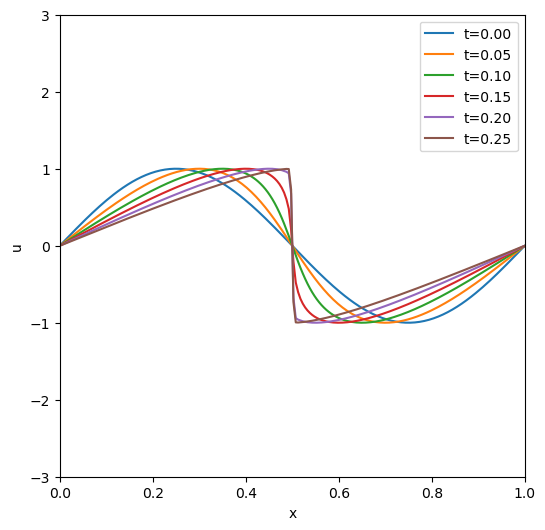

In [13]:
plt.figure(figsize=(6,6))
plt.xlabel("x")
plt.ylabel("u")
plt.xlim((0,1))
plt.ylim((-3,3))
#plt.title("Comparison of theoritical and numerical values @ t = 1")
for i in range(0, NT + 500, 500):    
    plt.plot(x, U[i], label=f't={(i*dt):2.2f}')
plt.legend()
plt.show()